2025-05-01 12:36:01.485435: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-01 12:36:01.485464: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-01 12:36:01.485468: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1746095761.485637   22066 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746095761.485826   22066 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


2025-05-01 12:36:06.617661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-01 12:36:08.224221: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


313/313 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.2358 - loss: 3.6863 - val_accuracy: 0.6182 - val_loss: 1.3482
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.5504 - loss: 1.7703 - val_accuracy: 0.6594 - val_loss: 1.2166
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.6010 - loss: 1.5098 - val_accuracy: 0.6611 - val_loss: 1.2193
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.6271 - loss: 1.3983 - val_accuracy: 0.6662 - val_loss: 1.2118
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.6446 - loss: 1.3111 - val_accuracy: 0.6713 - val_loss: 1.1898
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 536s 2s/step - accuracy: 0.6603 - loss: 1.2488 - val_accuracy: 0.6786 - val_loss: 1.1733
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.6613 - loss: 1.2388 - val_accuracy: 0.6746 - val_loss: 1.1853
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.6693 - loss: 1.2047 - val_accuracy: 0.681

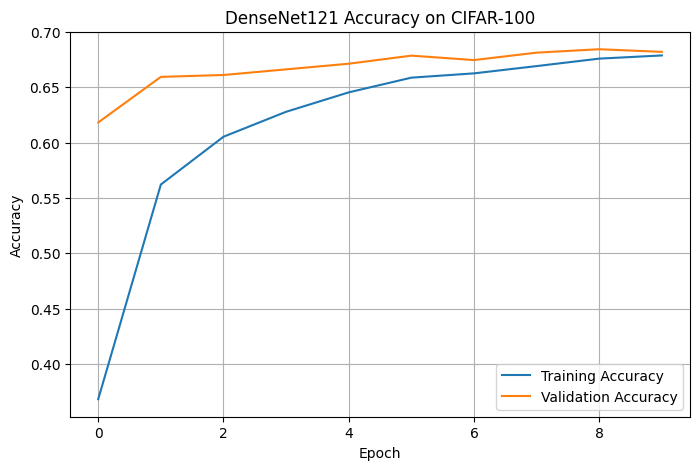

✅ Final Validation Accuracy (DenseNet121): 68.20%


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load CIFAR-100 dataset (80% train, 20% val)
(ds_train, ds_val), ds_info = tfds.load(
    "cifar100",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features['label'].num_classes

# Preprocessing for DenseNet121
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.densenet.preprocess_input(image)
    label = tf.one_hot(label, depth=num_classes)
    return image, label

batch_size = 128

train_ds = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load DenseNet121 base model
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False  # Freeze for feature extraction

# Add classifier head
model = models.Sequential([
    base_model,
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Plot accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DenseNet121 Accuracy on CIFAR-100')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Print final accuracy
final_val_acc = history.history['val_accuracy'][-1] * 100
print(f"✅ Final Validation Accuracy (DenseNet121): {final_val_acc:.2f}%")
